# Cross-validation of DAVE and Orcaflex Dynamics of Barge

Build a scene with the example barge ballasted down to 4m draft

In [1]:
from DAVE import *
s = Scene('100x30x8_barge.dave')

s.goal_seek(evaluate="s['Barge'].z",
    target=-4.0,
    change = "s['Barge'].mass")

s.solve_statics()

DAVEcore version = 2.0 from c:\python\miniconda3\envs\book\Lib\site-packages\DAVEcore.cp311-win_amd64.pyd
Blender found at: C:\Users\beneden\AppData\Local\Microsoft\WindowsApps\\blender-launcher.exe
Loading c:\python\miniconda3\envs\book\Lib\site-packages\DAVE\resources\100x30x8_barge.dave
Attempting to evaluate s['Barge'].z to -4.0 (now 0.0)
By changing the value of ("s['Barge'].mass",) (now 5000.0)
setting 5000.0 results in -1.6260162601572348
setting 5000.0001 results in -1.6260162926647246
setting 12302.882412937675 results in -4.000937370083893
setting 12299.99999992974 results in -4.000000000200788
      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 12299.999999312318


c:\python\miniconda3\envs\book\Lib\site-packages\DAVE\nodes.py:4631: UserWarning: BallastSystem.new_tank is outdated and may be removed in a future version.
  warn(


True

Show the model

No actors created for node Barge Ballast system


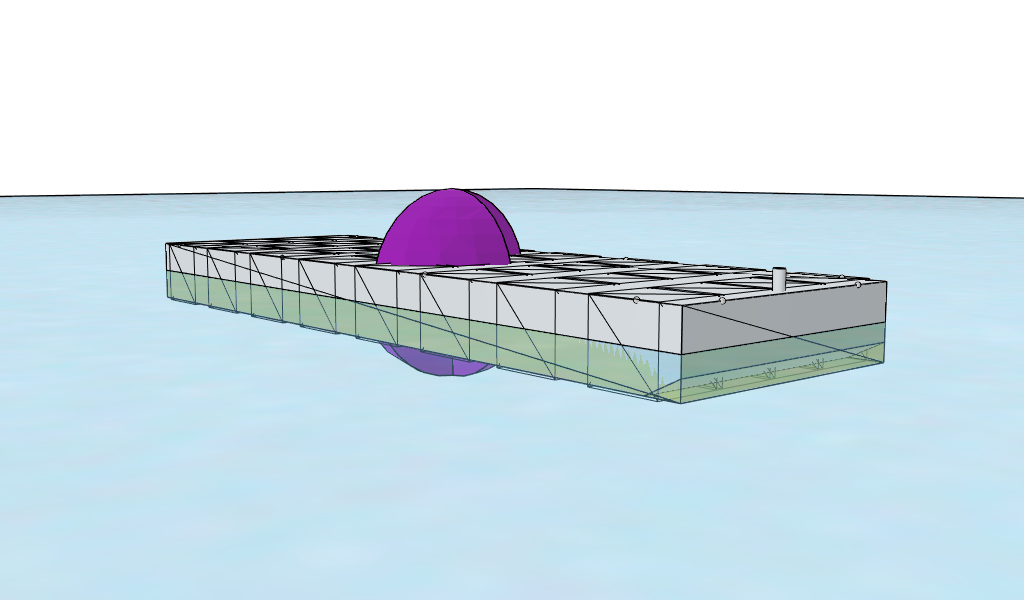

In [2]:
from DAVE.jupyter import *
show(s, show_global = True, camera_pos = (158.99328689012356, -83.11396799310523, 14.821261537388635), lookat = (18.24840759806191, 36.62760209655524, -6.699510976000989))

The buoyancy of the model comes from a buoyancy mesh. Unfortunately Orcaflex does not support meshes as buoyancy objects. 

The DAVE.marine package provides a function to create a linearized buoayncy node (HydSpring) from a buoyancy shape.

In [3]:
from DAVE.marine import *
linearize_buoyancy(s, s['Buoyancy mesh'])


Buoyancy mesh <HydSpring>

The buoyancy mesh node has now been replaced with a HydSpring node. Confusingly with the same name...

In [4]:
node = s['Buoyancy mesh']
type(node)

DAVE.nodes.HydSpring

Lets give is another name and report its properties

In [5]:
node.name = "Linear buoyancy"
report(node)


Property,Value,Unit,Remarks,Explained
BML,208.335,[m],,Vertical distance between cob and metacenter for pitch
BMT,18.752,[m],,Vertical distance between cob and metacenter for roll
COFX,-0.000,[m],,"Horizontal x-position Center of Floatation (center of waterplane area), relative to cob"
COFY,0.000,[m],,"Horizontal y-position Center of Floatation (center of waterplane area), relative to cob"
cob,"(50.000, 0.000, 2.000 )","[m,m,m]",parent axis,Center of buoyancy in
displacement_kN,120621.795,[kN],,Displacement when waterline is at waterline-elevation
kHeave,30155.449,[kN/m],,Heave stiffness
name,Linear buoyancy,,,"Name of the node (str), must be unique"
visible,True,[bool],,Determines if this node is visible in the viewport
waterline,2.000,[m],which is where is normally is,Waterline-elevation relative to cob for un-stretched heave-spring. Positive if cob is below the waterline


And lets double-check that it does not affect the equilibrium position of the barge, it should still be at -4.000 m and even-keel:

In [6]:
s.solve_statics()

report(s['Barge'],['global_position','heel','trim'])

Property,Value,Unit,Remarks,Explained
global_position,"(-0.000, 0.000, -4.000 )","[m,m,m]",global axis,The global position of the origin of the axis system
heel,0.000,[deg],,Heel in degrees. SB down is positive
trim,-0.000,[deg],,Trim in degrees. Bow-down is positive


In [7]:
from DAVE.frequency_domain import *
prepare_for_fd(s)

c:\python\miniconda3\envs\book\Lib\site-packages\mafredo\hyddb1.py:280: UserWarning: Guessing symmetry for c:\python\miniconda3\envs\book\Lib\site-packages\DAVE\resources\barge_100_30_4.dhyd to be XZ (PS/SB) because maximum heading = 180.0 deg
  warn(


Minimum damping for frequency domain analysis, as fraction of critical damping based on diagonal terms.

```python
FD_GLOBAL_MIN_DAMPING_FRACTION = 0.005
```


In [8]:
from DAVE.frequency_domain import RAO_1d
wave_direction = 90
min = 0.1
max = 4
steps = 100
omega = np.linspace(min,max,steps)
data = RAO_1d(s, omega, wave_direction)

Increasing diagonal damping for mode 0 to (11.619211995300269+0j) ,global minimum damping set to 0.5% of critical damping for this mode (settings.FD_GLOBAL_MIN_DAMPING_FRACTION)
Increasing diagonal damping for mode 1 to (12.986510333521593+0j) ,global minimum damping set to 0.5% of critical damping for this mode (settings.FD_GLOBAL_MIN_DAMPING_FRACTION)
Increasing diagonal damping for mode 2 to (494.8574271826015+0j) ,global minimum damping set to 0.5% of critical damping for this mode (settings.FD_GLOBAL_MIN_DAMPING_FRACTION)
Increasing diagonal damping for mode 3 to (21873.055149462765+0j) ,global minimum damping set to 0.5% of critical damping for this mode (settings.FD_GLOBAL_MIN_DAMPING_FRACTION)
Increasing diagonal damping for mode 4 to (348545.55674519954+0j) ,global minimum damping set to 0.5% of critical damping for this mode (settings.FD_GLOBAL_MIN_DAMPING_FRACTION)
Increasing diagonal damping for mode 5 to (24358.207112105643+0j) ,global minimum damping set to 0.5% of critic

Text(0.5, 1.0, 'Roll RAO')

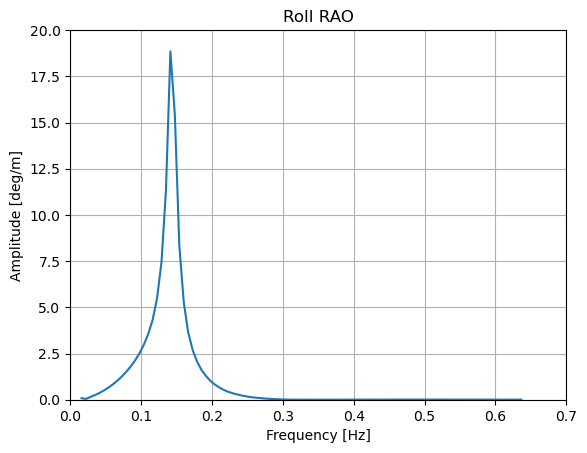

In [9]:
import matplotlib.pyplot as plt


roll = data[3]

roll_amp = abs(roll) # radians !


frequency_hz = omega  / (2*np.pi)

plt.plot(frequency_hz, np.degrees(roll_amp))
plt.grid('on')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [deg/m]')
plt.ylim([0, 20])
plt.xlim([0, 0.7])
plt.title('Roll RAO')


Text(0.5, 1.0, 'Heave RAO')

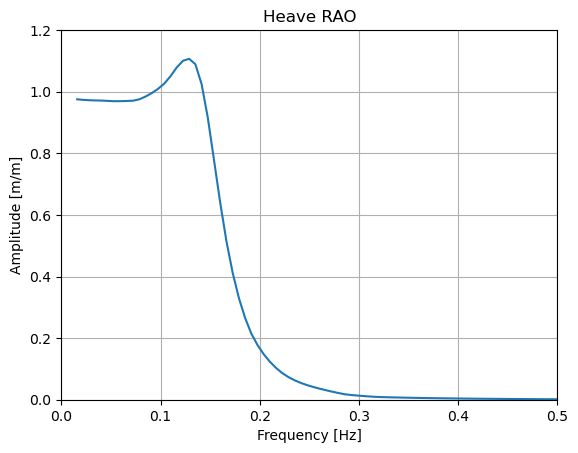

In [10]:

plt.plot(frequency_hz, abs(data[2]))
plt.grid('on')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m/m]')
plt.ylim([0, 1.2])
plt.xlim([0, 0.5])
plt.title('Heave RAO')


## Time response

## Orcaflex

This model can be exported to an orcaflex .yml model file.

In [11]:
from DAVE.io.orcaflex import *

export_ofx_yml(s,'barge.yml')


created barge.obj
created barge.yml


c:\python\miniconda3\envs\book\Lib\site-packages\DAVE\io\orcaflex.py:142: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eu = total.as_euler(seq='xyz', degrees=True).tolist()


Now it is possible that you, like me, do not have orcaflex. You can still download the orcaflex demo to open and view the .yml model file

![screenshot](screenshot_barge.png)

Now there is some explaining to do on how exactly this was exported.

The hydrodynamics are easy: the first order wave forces, added mass and damping were exported to the vessel-type.

The hydrostatics are a bit more complex, but in a nice way.

The mass of the vessel is exported as a 6D buoy. This 6D buoy is then connected to the vessel.
The buoyancy of the vessel is exported to the vessel type. This means that the mass of the vessel-type is set to almost zero. The effect of that is that the stiffness matrix of the vessel type, which normally includes the weight components, is reduced to purely the hydrostatic matrix. So based on KM, not KG. If you have ever tried to model a vessel in orcaflex using different 6D buoys (for example a vessel with a crane) then you will certainly appreciate this method. 

So:
- Hydrodynamics and Buoyancy go into the vessel-type (everything related to water)
- Mass and inertia go into a 6D buoy

## Orcaflex results

![ofx_results](ofx_barge_rao.png)

---

end